# Jacobian Norm Analysis at t=T (Starting Step)

This notebook calculates the Jacobian norm of the conditional noise with respect to the condition (prompt embedding) at **t=T**, where **T** denotes the **starting step** of the reverse diffusion process (pure noise).

We compare memorized and non-memorized prompts to see if there's a difference in sensitivity to the condition at the very beginning of generation.

In [84]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from diffusers import DDIMScheduler, StableDiffusionPipeline

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
BASE_DIR = "/home/gpuadmin/cssin/init_noise_diffusion_memorization"
PROMPTS_DIR = os.path.join(BASE_DIR, "prompts")
OUTPUT_DIR = os.path.join(BASE_DIR, "results", "jacobian_t_T_analysis")
os.makedirs(OUTPUT_DIR, exist_ok=True)

sys.path.append(BASE_DIR)

# Try importing local pipeline if available, otherwise standard
try:
    from local_sd_pipeline import LocalStableDiffusionPipeline
except ImportError:
    print("LocalStableDiffusionPipeline not found, using standard.")
    LocalStableDiffusionPipeline = StableDiffusionPipeline

In [85]:
def compute_jacobian_norm_batched(unet, latents, t, prompt_embeds, num_projections=1):
    """
    Batched Hutchinson estimator for ||J||_F.
    Returns a tensor of shape (batch_size,) containing the Jacobian norm for each sample.
    """
    prompt_embeds = prompt_embeds.detach()
    latents = latents.detach()
    
    batch_size = latents.shape[0]
    
    with torch.enable_grad():
        prompt_embeds.requires_grad_(True)
        # Forward pass
        noise_pred = unet(latents, t, encoder_hidden_states=prompt_embeds).sample
        
        sq_norm_sum = torch.zeros(batch_size, device=latents.device)
        
        for k in range(num_projections):
            # Random probe v
            v = torch.randn_like(noise_pred)
            
            v_dot_eps_sum = torch.sum(noise_pred * v)
            
            retain = (k < num_projections - 1)
            grads = torch.autograd.grad(v_dot_eps_sum, prompt_embeds, retain_graph=retain, create_graph=False)[0]
            
            # Squared norm per sample
            grads_sq_flat = grads.view(batch_size, -1).pow(2)
            sample_sq_norms = grads_sq_flat.sum(dim=1) # [B]
            
            sq_norm_sum += sample_sq_norms.detach()
            
        est_frob_sq = sq_norm_sum / max(1, float(num_projections))
        return est_frob_sq.sqrt() # [B]

def load_prompts(num_prompts=500):
    mem_path = os.path.join(PROMPTS_DIR, "memorized_laion_prompts.csv")
    unmem_path = os.path.join(PROMPTS_DIR, "unmemorized_prompts.csv")
    
    df_mem = pd.read_csv(mem_path, sep=';')
    df_unmem = pd.read_csv(unmem_path, sep=';')
    
    mem_prompts = df_mem['Caption'].tolist()
    unmem_prompts = df_unmem['Caption'].tolist()
    
    # Ensure we don't exceed available prompts
    mem_prompts = mem_prompts[:min(len(mem_prompts), num_prompts)]
    unmem_prompts = unmem_prompts[:min(len(unmem_prompts), num_prompts)]
    
    print(f"Loaded {len(mem_prompts)} memorized prompts and {len(unmem_prompts)} unmemorized prompts.")
    return mem_prompts, unmem_prompts

In [86]:
# Configuration
model_id = "CompVis/stable-diffusion-v1-4"
NUM_INIT_NOISES = 100
NUM_PROMPTS = 500
BATCH_SIZE = 10 
NUM_INFERENCE_STEPS = 1000 # Using 1000 steps to define T as the pure noise starting point

# Load Pipeline
pipeline = LocalStableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32).to(device)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.set_progress_bar_config(disable=True)

/home/gpuadmin/cssin/init_noise_diffusion_memorization/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [87]:
# 1. Extract Prompts
mem_prompts, unmem_prompts = load_prompts(NUM_PROMPTS)

# 2. Generate Init Noises
print("Generating Init Noises...")
gen = torch.Generator(device=device).manual_seed(42)
init_noises = torch.randn(
    (NUM_INIT_NOISES, pipeline.unet.config.in_channels, 64, 64),
    generator=gen,
    device=device,
    dtype=torch.float32
)

# Define T as the starting step
pipeline.scheduler.set_timesteps(NUM_INFERENCE_STEPS)
t_T = pipeline.scheduler.timesteps[0]
print(f"Using Starting Step T={t_T.item()}")

Loaded 500 memorized prompts and 100 unmemorized prompts.
Generating Init Noises...
Using Starting Step T=1000


In [ ]:
# 3. Compute Jacobian Norms
results = []
groups = [("Memorized", mem_prompts), ("Unmemorized", unmem_prompts)]

for group_name, prompts in groups:
    print(f"Processing {group_name} prompts...")
    for p_idx, prompt in enumerate(tqdm(prompts)):
        # Encode prompt once: [1, Seq, Dim]
        prompt_embeds = pipeline._encode_prompt(prompt, device, 1, False, None)
        
        # Loop over noise batches
        jacob_norms_prompt = []
        num_batches = (NUM_INIT_NOISES + BATCH_SIZE - 1) // BATCH_SIZE
        
        for b in range(num_batches):
            start = b * BATCH_SIZE
            end = min(start + BATCH_SIZE, NUM_INIT_NOISES)
            current_bs = end - start
            
            batch_noises = init_noises[start:end]
            batch_prompt_embeds = prompt_embeds.repeat(current_bs, 1, 1)
            
            latent_input = pipeline.scheduler.scale_model_input(batch_noises, t_T)
            
            j_norms = compute_jacobian_norm_batched(pipeline.unet, latent_input, t_T, batch_prompt_embeds)
            jacob_norms_prompt.extend(j_norms.cpu().tolist())
        
        # Store results
        for s_idx, val in enumerate(jacob_norms_prompt):
            results.append({
                "Group": group_name,
                "Prompt_Idx": p_idx,
                "Sample_Idx": s_idx,
                "JacobianNorm": val
            })

df_results = pd.DataFrame(results)
save_path = os.path.join(OUTPUT_DIR, "jacobian_norms_t_T.csv")
df_results.to_csv(save_path, index=False)
print(f"Saved results to {save_path}")

Calculating optimal classification threshold...

Optimal Threshold: 2.833834
Condition: Memorized > Threshold
Accurracy: 99.65%
Misclassification Rate: 0.35%

=== Misclassification Statistics ===
Optimal Threshold (Sample-based): 2.833834

[Sample-Level] (Total Noise Instances)
Memorized -> Classified as Unmemorized: 6 / 2000 (0.30%)
Unmemorized -> Classified as Memorized: 8 / 2000 (0.40%)

[Prompt-Level] (Strict: Misclassified if ANY sample is wrong)
Memorized -> Classified as Unmemorized: 2 / 20 (10.00%)
Unmemorized -> Classified as Memorized: 6 / 20 (30.00%)

Analyzing Misclassified Memorized Prompts...
Found 6 misclassified noise instances (Memorized -> Unmemorized)
Generating comparison for Prompt 19, Sample 12 (J=2.3246)...
Prompt: DC All Stars podcast...


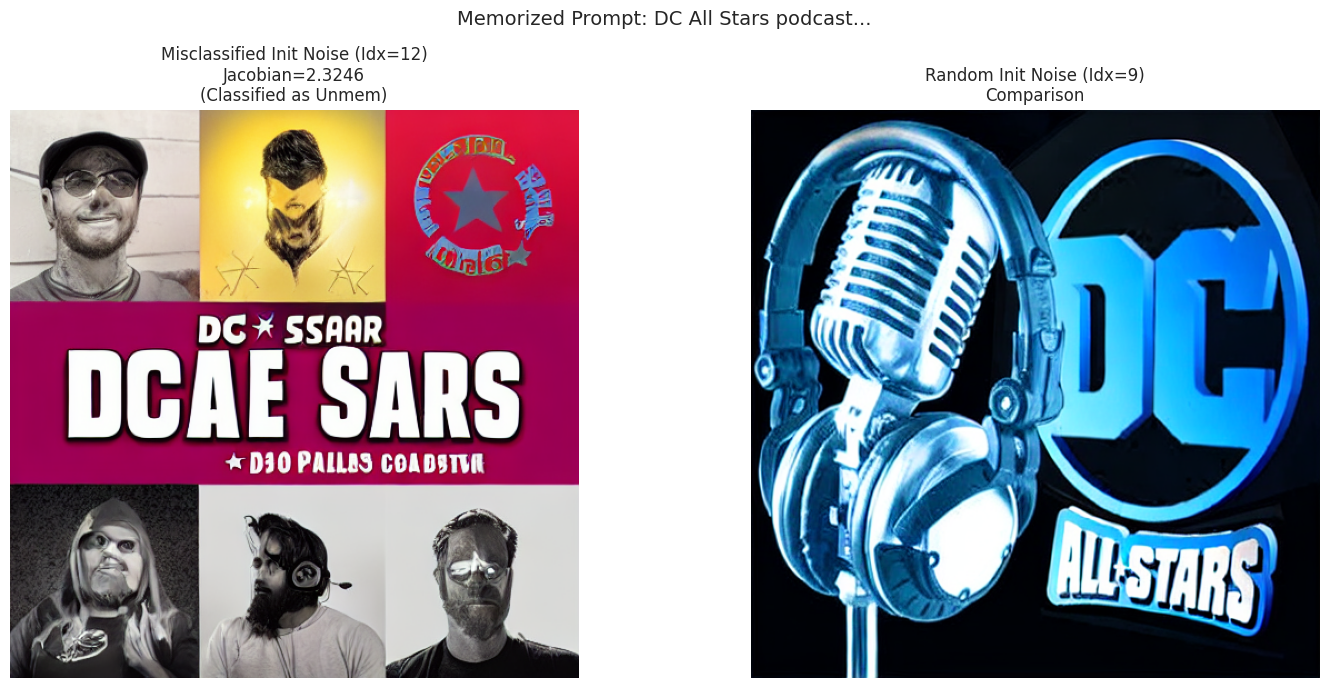

Generating comparison for Prompt 2, Sample 33 (J=2.6229)...
Prompt: Mothers influence on her young hippo...


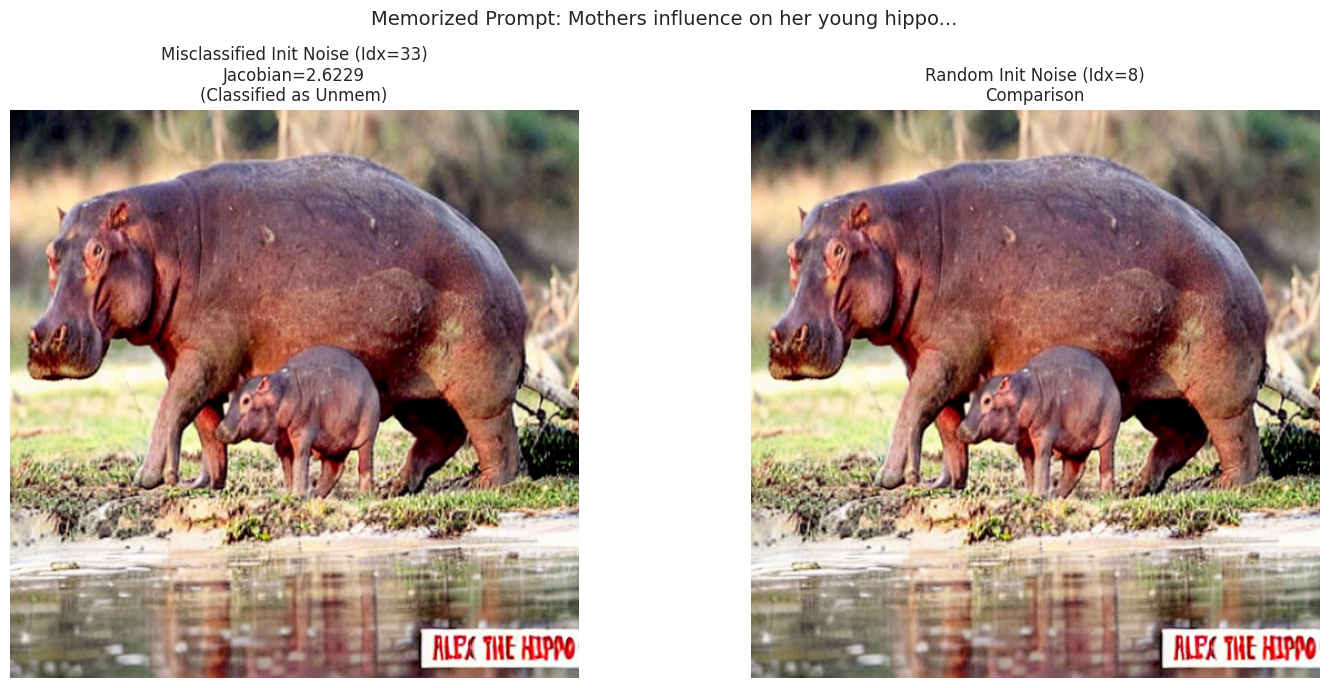

Saved 2 comparison images to /home/gpuadmin/cssin/init_noise_diffusion_memorization/results/jacobian_t_T_analysis/misclassified_comparisons


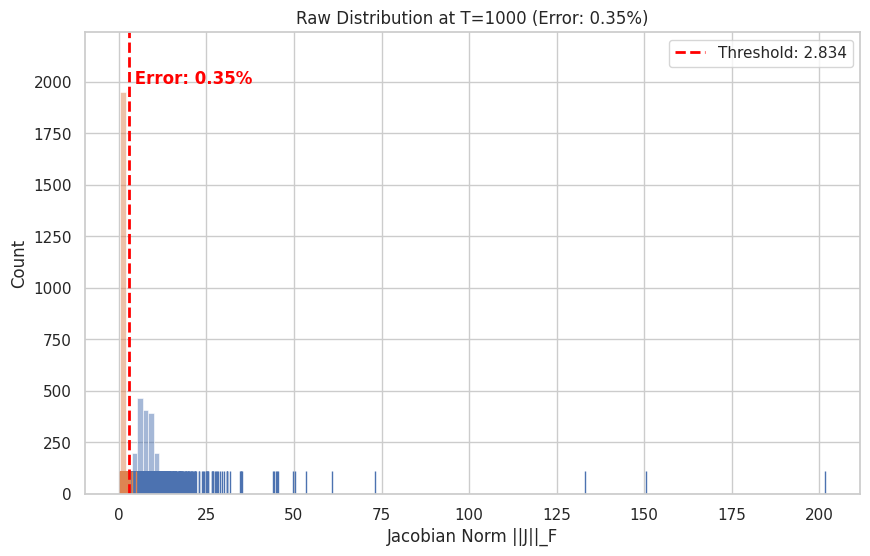

Saved histogram to /home/gpuadmin/cssin/init_noise_diffusion_memorization/results/jacobian_t_T_analysis/jacobian_norm_hist_t_T.png


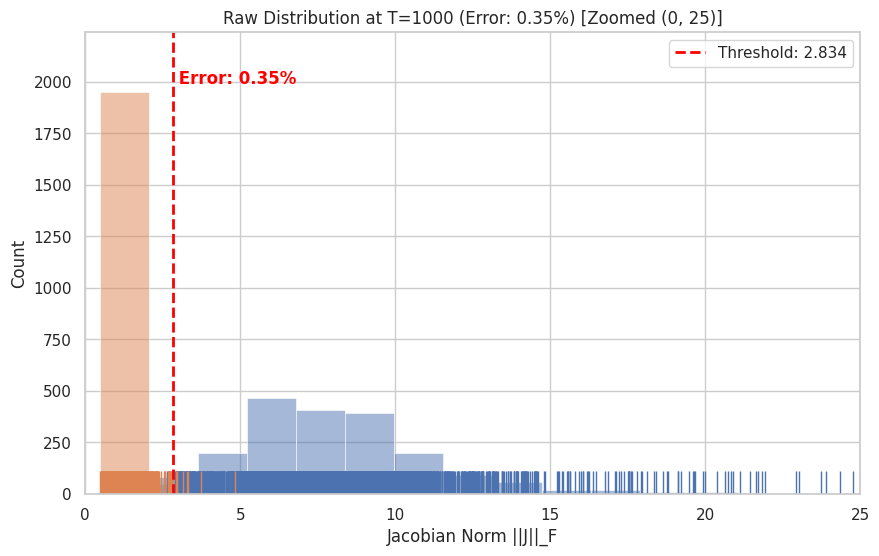

Saved histogram to /home/gpuadmin/cssin/init_noise_diffusion_memorization/results/jacobian_t_T_analysis/jacobian_norm_hist_t_T_zoomed_0_25.png


/tmp/ipykernel_3962504/279163591.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x="Group", y="JacobianNorm", palette="Set2")


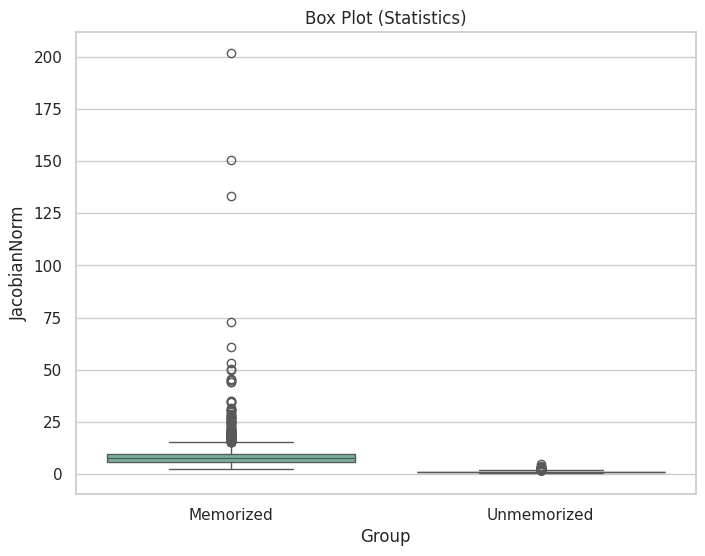

Saved boxplot to /home/gpuadmin/cssin/init_noise_diffusion_memorization/results/jacobian_t_T_analysis/jacobian_norm_boxplot_t_T.png


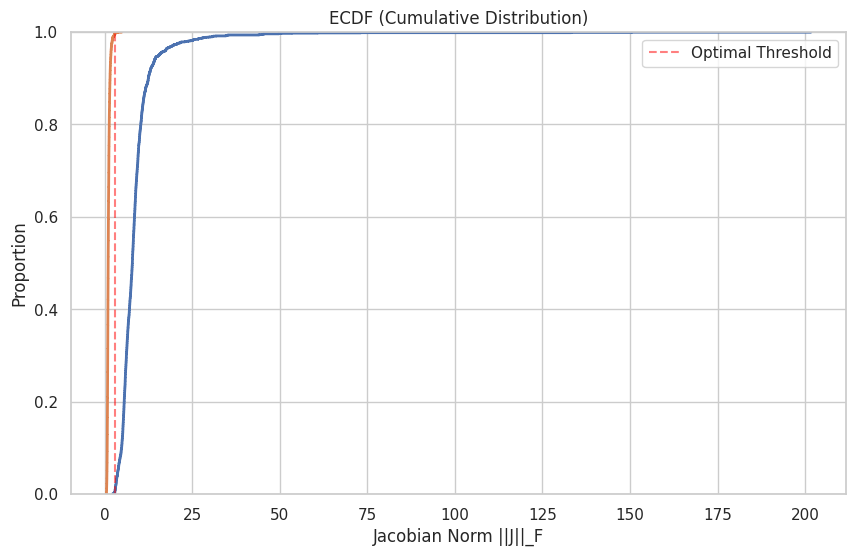

Saved ECDF to /home/gpuadmin/cssin/init_noise_diffusion_memorization/results/jacobian_t_T_analysis/jacobian_norm_ecdf_t_T.png


In [90]:
# 4. Classification Analysis & Visualization
    
# --- Classification Analysis (Optimal Threshold) ---
print("Calculating optimal classification threshold...")

# Sort data for efficient threshold search
df_sorted = df_results.sort_values(by="JacobianNorm").reset_index(drop=True)
y_sorted = (df_sorted["Group"] == "Memorized").astype(int).values # 1=Memorized, 0=Unmemorized
values = df_sorted["JacobianNorm"].values

n_total = len(y_sorted)
n_mem_total = np.sum(y_sorted)
n_unmem_total = n_total - n_mem_total

# Calculate cumulative counts of classes as we traverse the sorted values
cum_mem = np.cumsum(y_sorted)
cum_unmem = np.cumsum(1 - y_sorted)

# Evaluate accuracy for every possible split point i (Threshold = values[i])
# Case A: Predict Mem > T, Unmem < T
acc_A = (cum_unmem + (n_mem_total - cum_mem)) / n_total

# Case B: Predict Mem < T, Unmem > T
acc_B = (cum_mem + (n_unmem_total - cum_unmem)) / n_total

# Find best accuracy and corresponding index
idx_A = np.argmax(acc_A)
idx_B = np.argmax(acc_B)

if acc_A[idx_A] >= acc_B[idx_B]:
    best_acc = acc_A[idx_A]
    best_idx = idx_A
    direction = "Memorized > Threshold"
else:
    best_acc = acc_B[idx_B]
    best_idx = idx_B
    direction = "Memorized < Threshold"
    
best_thresh = values[best_idx]
misclassified_rate = (1 - best_acc) * 100

print(f"\nOptimal Threshold: {best_thresh:.6f}")
print(f"Condition: {direction}")
print(f"Accurracy: {best_acc*100:.2f}%")
print(f"Misclassification Rate: {misclassified_rate:.2f}%")

# --- Misclassification Details ---

# 1. Sample-Level
if direction == "Memorized > Threshold":
    mem_as_unmem = df_results[(df_results["Group"] == "Memorized") & (df_results["JacobianNorm"] <= best_thresh)]
    unmem_as_mem = df_results[(df_results["Group"] == "Unmemorized") & (df_results["JacobianNorm"] > best_thresh)]
else:
    mem_as_unmem = df_results[(df_results["Group"] == "Memorized") & (df_results["JacobianNorm"] >= best_thresh)]
    unmem_as_mem = df_results[(df_results["Group"] == "Unmemorized") & (df_results["JacobianNorm"] < best_thresh)]

# 2. Prompt-Level (Strict: Any sample misclassified -> Prompt misclassified)
# n_mem_prompts, n_unmem_prompts calculation
mem_prompt_indices = df_results[df_results["Group"] == "Memorized"]["Prompt_Idx"].unique()
unmem_prompt_indices = df_results[df_results["Group"] == "Unmemorized"]["Prompt_Idx"].unique()
    
n_mem_prompts = len(mem_prompt_indices)
n_unmem_prompts = len(unmem_prompt_indices)
    
if direction == "Memorized > Threshold":
    # Memorized Prompt is misclassified if ANY of its samples are <= Threshold
    # i.e., min(samples) <= Threshold
    mis_mem_prompt_mask = df_results[df_results["Group"] == "Memorized"].groupby("Prompt_Idx")["JacobianNorm"].min() <= best_thresh
    count_mem_misclassified = mis_mem_prompt_mask.sum()
        
    # Unmemorized Prompt is misclassified if ANY of its samples are > Threshold
    # i.e., max(samples) > Threshold
    mis_unmem_prompt_mask = df_results[df_results["Group"] == "Unmemorized"].groupby("Prompt_Idx")["JacobianNorm"].max() > best_thresh
    count_unmem_misclassified = mis_unmem_prompt_mask.sum()
        
else: # Memorized < Threshold
    # Memorized Prompt is misclassified if ANY of its samples are >= Threshold
    # i.e., max(samples) >= Threshold
    mis_mem_prompt_mask = df_results[df_results["Group"] == "Memorized"].groupby("Prompt_Idx")["JacobianNorm"].max() >= best_thresh
    count_mem_misclassified = mis_mem_prompt_mask.sum()
        
    # Unmemorized Prompt is misclassified if ANY of its samples are < Threshold
    # i.e., min(samples) < Threshold
    mis_unmem_prompt_mask = df_results[df_results["Group"] == "Unmemorized"].groupby("Prompt_Idx")["JacobianNorm"].min() < best_thresh
    count_unmem_misclassified = mis_unmem_prompt_mask.sum()

print(f"\n=== Misclassification Statistics ===")
print(f"Optimal Threshold (Sample-based): {best_thresh:.6f}")
    
print(f"\n[Sample-Level] (Total Noise Instances)")
print(f"Memorized -> Classified as Unmemorized: {len(mem_as_unmem)} / {n_mem_total} ({len(mem_as_unmem)/n_mem_total*100:.2f}%)")
print(f"Unmemorized -> Classified as Memorized: {len(unmem_as_mem)} / {n_unmem_total} ({len(unmem_as_mem)/n_unmem_total*100:.2f}%)")

print(f"\n[Prompt-Level] (Strict: Misclassified if ANY sample is wrong)")
print(f"Memorized -> Classified as Unmemorized: {count_mem_misclassified} / {n_mem_prompts} ({count_mem_misclassified/n_mem_prompts*100:.2f}%)")
print(f"Unmemorized -> Classified as Memorized: {count_unmem_misclassified} / {n_unmem_prompts} ({count_unmem_misclassified/n_unmem_prompts*100:.2f}%)")

# 5. Visualizing Misclassified Memorized Prompts
print("\nAnalyzing Misclassified Memorized Prompts...")

# Filter: Memorized prompts that were classified as Unmemorized
if direction == "Memorized > Threshold":
    # Misclassified: Mem <= Threshold
    misclassified_mask = (df_results["Group"] == "Memorized") & (df_results["JacobianNorm"] <= best_thresh)
else:
    # Misclassified: Mem >= Threshold
    misclassified_mask = (df_results["Group"] == "Memorized") & (df_results["JacobianNorm"] >= best_thresh)
    
df_misclassified = df_results[misclassified_mask].copy()

print(f"Found {len(df_misclassified)} misclassified noise instances (Memorized -> Unmemorized)")

if len(df_misclassified) > 0:
    # Sort by deviation from threshold (most severe misclassifications first)
    if direction == "Memorized > Threshold":
        # Sort ascending (smaller is 'worse' for Memorized)
        df_misclassified = df_misclassified.sort_values(by="JacobianNorm")
    else:
        # Sort descending (larger is 'worse' for Memorized)
        df_misclassified = df_misclassified.sort_values(by="JacobianNorm", ascending=False)
        
    vis_count = 0
    img_output_dir = os.path.join(OUTPUT_DIR, "misclassified_comparisons")
    os.makedirs(img_output_dir, exist_ok=True)
    
    # We want distinct prompts if possible to see variety
    processed_prompts = set()
    
    for idx, row in df_misclassified.iterrows():
        if vis_count >= 10: break
        
        p_idx = int(row['Prompt_Idx'])
        s_idx = int(row['Sample_Idx'])
        # Retrieve Caption (Need to re-access prompt list)
        caption = mem_prompts[p_idx]
        j_norm = row['JacobianNorm']
        
        if p_idx in processed_prompts:
            continue
        processed_prompts.add(p_idx)
        
        print(f"Generating comparison for Prompt {p_idx}, Sample {s_idx} (J={j_norm:.4f})...\nPrompt: {caption[:60]}...")
        
        # 1. Image with Misclassified Noise
        # Ensure we use the correct init_noises tensor saved/generated earlier
        # We assume 'init_noises' is available from Cell 2
        bad_noise = init_noises[s_idx].unsqueeze(0).to(device) 
        
        with torch.no_grad():
            image_bad = pipeline(caption, latents=bad_noise, num_inference_steps=50).images[0]
            
        # 2. Image with Random Comparison Noise
        rand_s_idx = np.random.randint(0, NUM_INIT_NOISES)
        while rand_s_idx == s_idx:
            rand_s_idx = np.random.randint(0, NUM_INIT_NOISES)
        
        rand_noise = init_noises[rand_s_idx].unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_rand = pipeline(caption, latents=rand_noise, num_inference_steps=50).images[0]
        
        # Plot
        fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        
        ax[0].imshow(image_bad)
        ax[0].set_title(f"Misclassified Init Noise (Idx={s_idx})\nJacobian={j_norm:.4f}\n(Classified as Unmem)")
        ax[0].axis('off')
        
        ax[1].imshow(image_rand)
        ax[1].set_title(f"Random Init Noise (Idx={rand_s_idx})\nComparison")
        ax[1].axis('off')
        
        plt.suptitle(f"Memorized Prompt: {caption[:50]}...", fontsize=14)
        plt.tight_layout()
        
        save_path = os.path.join(img_output_dir, f"misclassified_p{p_idx}_s{s_idx}.png")
        plt.savefig(save_path)
        plt.show()
        
        vis_count += 1
        
    print(f"Saved {vis_count} comparison images to {img_output_dir}")

# --- Plotting ---
sns.set_theme(style="whitegrid")

def plot_hist_with_threshold(data, threshold, xlim=None, suffix=""):
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=data, 
        x="JacobianNorm", 
        hue="Group", 
        kde=False,           
        element="bars",      
        stat="count",        
        common_norm=False,   
        multiple="layer",    
        alpha=0.5          
    )
    sns.rugplot(data=data, x="JacobianNorm", hue="Group", height=0.05)
    
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f"Threshold: {threshold:.3f}")
    
    y_lim = plt.ylim()
    text_y = y_lim[1] * 0.9
    
    # Handle xlim for text positioning
    if xlim:
        plt.xlim(xlim)
        # Check if threshold is visible
        if xlim[0] <= threshold <= xlim[1]:
             plt.text(threshold, text_y, f" Error: {misclassified_rate:.2f}%", color='red', fontweight='bold', va='center')
    else:
        plt.text(threshold, text_y, f" Error: {misclassified_rate:.2f}%", color='red', fontweight='bold', va='center')

    title = f"Raw Distribution at T={t_T.item()} (Error: {misclassified_rate:.2f}%)"
    if xlim: title += f" [Zoomed {xlim}]"
    plt.title(title)
    plt.xlabel("Jacobian Norm ||J||_F")
    plt.legend()
    
    filename = f"jacobian_norm_hist_t_T{suffix}.png"
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path)
    plt.show()
    print(f"Saved histogram to {save_path}")

# 1. Full Range Histogram
plot_hist_with_threshold(df_results, best_thresh, xlim=None, suffix="")

# 2. Zoomed Histogram
plot_hist_with_threshold(df_results, best_thresh, xlim=(0, 25), suffix="_zoomed_0_25")

# B. Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_results, x="Group", y="JacobianNorm", palette="Set2")
plt.title("Box Plot (Statistics)")

save_path_box = os.path.join(OUTPUT_DIR, "jacobian_norm_boxplot_t_T.png")
plt.savefig(save_path_box)
plt.show()
print(f"Saved boxplot to {save_path_box}")

# C. ECDF
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df_results, x="JacobianNorm", hue="Group", linewidth=2)
plt.axvline(x=best_thresh, color='red', linestyle='--', alpha=0.5, label="Optimal Threshold")
plt.title("ECDF (Cumulative Distribution)")
plt.xlabel("Jacobian Norm ||J||_F")
plt.legend()

save_path_ecdf = os.path.join(OUTPUT_DIR, "jacobian_norm_ecdf_t_T.png")
plt.savefig(save_path_ecdf)
plt.show()
print(f"Saved ECDF to {save_path_ecdf}")